In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


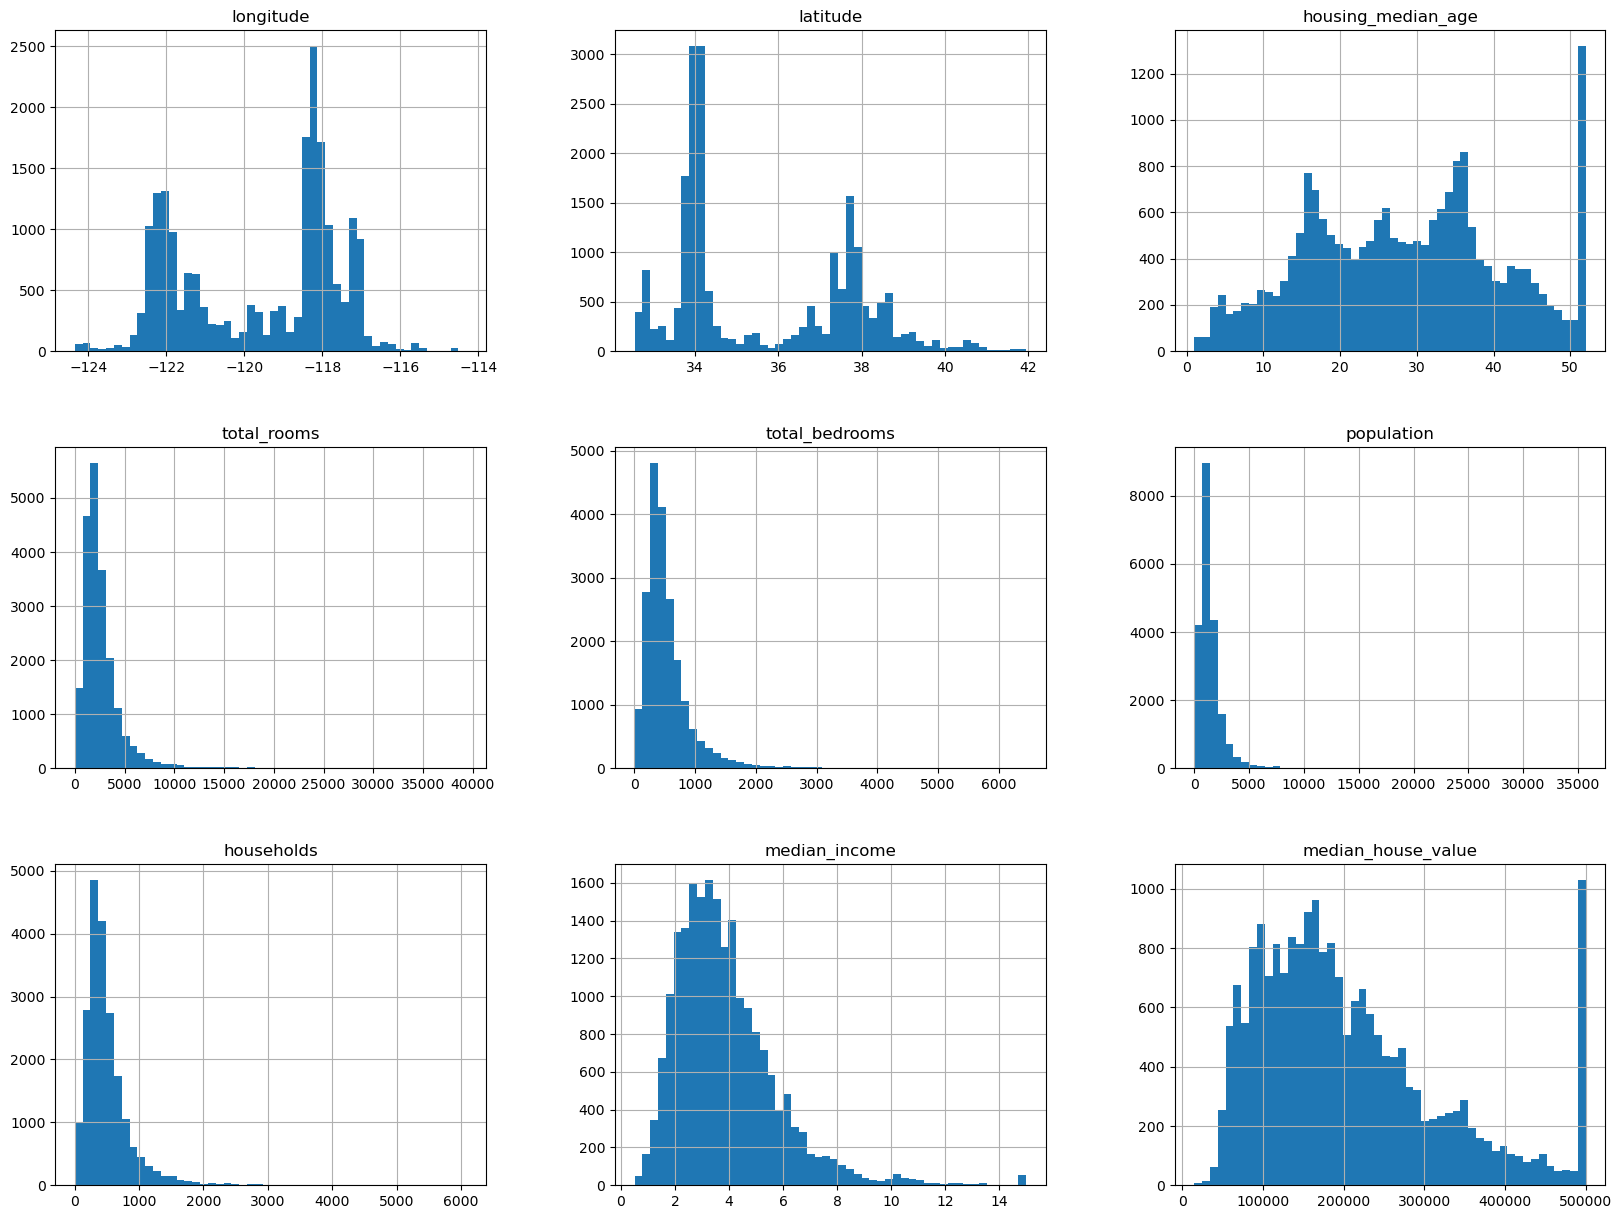

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20,15))
plt.show()

In [7]:
# Create a testset
import numpy as np 

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(test_set)

4128

In [9]:
len(train_set)

16512

In [10]:
np.random.seed(42)

In [11]:
from zlib import crc32
# PURPOSE : Determines whether a given identifier belongs to the test set based on a hash value and a specified test ratio.
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32


# PURPOSE : Splits the dataset into training and test sets based on unique identifiers 
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Operation:
- Extracts the identifiers from the specified column in the dataset.

- Applies the is_id_in_test_set function to each identifier to determine if it belongs to the test set.

- Uses the boolean mask in_test_set to split the data into two sets:
    - data.loc[~in_test_set]: The training set (identifiers not in the test set).
    - data.loc[in_test_set]: The test set (identifiers in the test set).


In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [14]:
from sklearn.model_selection import train_test_split

train_set, test_split = train_test_split(housing, test_size = 0.2, random_state = 42)

In [15]:
test_set["total_bedrooms"].isnull().sum()

45

In [16]:
from scipy.stats import binom 

sample_size = 1000
ratio_fem = 0.511
prob_too_small = binom(sample_size, ratio_fem).cdf(485-1)
prob_too_large = 1 - binom(sample_size, ratio_fem).cdf(535)
print(prob_too_small + prob_too_large)

0.10736798530929909


In [17]:
#shows another way to estimate the probability of bad sample

np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_fem).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

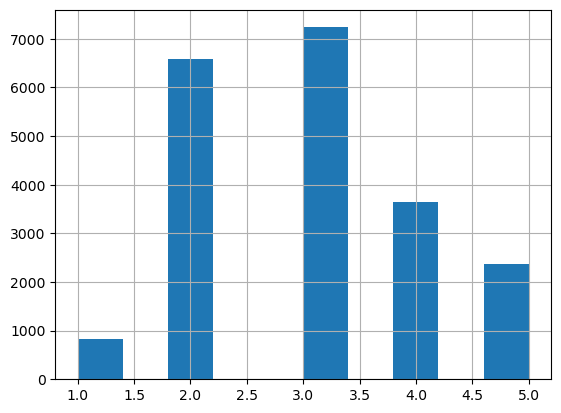

In [18]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf],
                              labels = [1,2,3,4,5])
housing["income_cat"].hist()
plt.show()

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit
# PURPOSE :  This part of the code creates stratified splits of the dataset, ensuring each split has the same distribution of income categories as the original dataset.
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [20]:
strat_train_set, strat_test_set = strat_splits[0]

In [21]:
#This directly creates stratified training and test sets.
strat_train_set, strat_test_set = train_test_split(
    housing, test_size = 0.2, stratify=housing["income_cat"], random_state = 42
)

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [23]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


<Axes: xlabel='longitude', ylabel='latitude'>

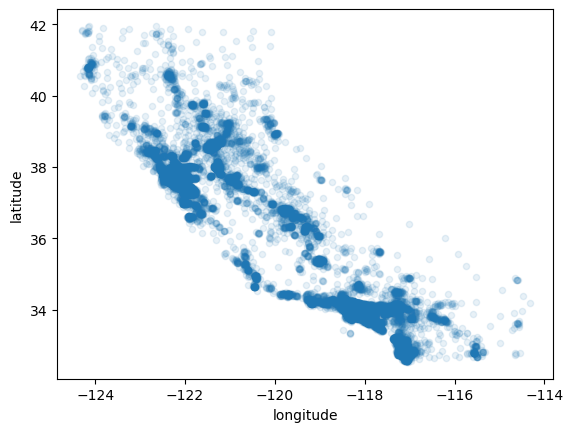

In [24]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

NameError: name 'save_fig' is not defined

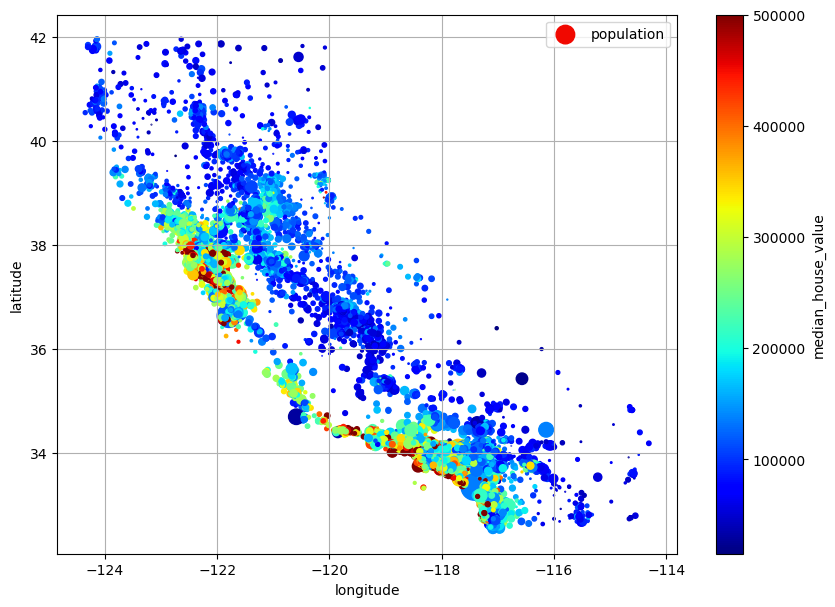

In [25]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, 
             s=housing["population"]/ 100, label = "population", 
             c= "median_house_value", cmap = "jet", colorbar = True,
             legend = True, sharex = False, figsize = (10,7))
save_fig("housing_prices_scatterplot")
plt.show()

## LOOKING FOR CORRELATIONS

In [26]:
# We are going to find the correlation between every attribute using the .corr method, standard correlation coefficient 

corr_matrix = housing.corr(numeric_only = True)

In [27]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

NameError: name 'save_fig' is not defined

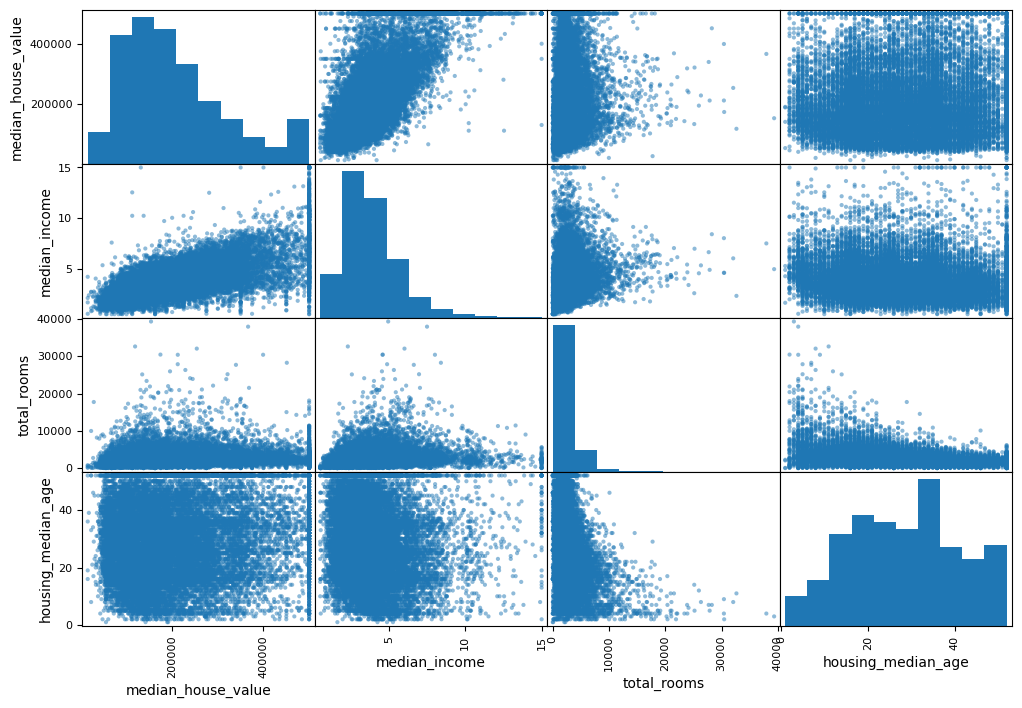

In [28]:
from pandas.plotting import scatter_matrix 

attributes  = ["median_house_value", "median_income", "total_rooms", 
               "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))
save_fig("scatter_matrix_plot")
plt.show()

In [ ]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value",
            alpha = 0.1)

## EXPERIMENTING WITH ATTRIBUTES COMBINATIONS 

In [ ]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"] 

In [ ]:
corr_matrix = housing.corr(numeric_only = True)

corr_matrix["median_house_value"].sort_values(ascending = False)